## Biodiversity Intactness Index change in Phoenix, AZ
Mapping fires with true color and false color imagery and visualizing its impacts socioeconomically. 
 
### Author: Isabella Segarra 
[Link to Github repository](https://github.com/IsabellaSegarra/eds220-hwk4)

### Objective:


### About the data:
#### Biodiversity Intactness Index (BII) Time Series  
This data is accessed through the Microsoft Planetary Computer.

#### Phoenix Subdivision Shapefile


### Analysis:
1.




In [1]:
# Environment set-up 
import pandas as pd # for data wrangling
import numpy as np  # for data wrangling 

import geopandas as gpd # for geospatial data 
import os # for data import

import matplotlib.pyplot as plt  # for visualizations 

import xarray as xr # for Netcdf4 data 
import rioxarray as rio # for raster data 

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

from shapely.geometry import box

## Data import and exploration

### Biodiversity Intactness Index (BII) Time Series 
In this step I will acess the `io-biodiversity` catalog from the *Microsoft Planetary Computer*.

In [3]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


catalog.get_collections()
collections = list(catalog.get_collections()) # Turn generator into list

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the io-biodiversity collection
io_biodiversity = catalog.get_child('io-biodiversity')
io_biodiversity

Number of collections: 126


<CollectionClient id=io-biodiversity>

Explain here about what you learn from above.

In [5]:
# Explore catalog metadata 
print('Title:', io_biodiversity.title)
print('Description: ', io_biodiversity.description)

Title: Biodiversity Intactness
Description:  Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020.

Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity m

Further refine the `io-biodiversiry` to 2017 and 2020 rasters and with the following coordinates to match the Pheonix, AZ region.

[-112.826843, 32.974108, -111.184387, 33.863574]

In [6]:
# time range of study
time_range = "2017-01-01/2020-01-01"

In [7]:
# bbox 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

In [8]:
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox, 
    datetime = time_range)

# Get items from search
items = search.item_collection()

# Determine number of items in search
len(items)

4

In [17]:
# Get first item in the catalog search
item = items[0]
type(item)

pystac.item.Item

In [ ]:
# find the years from the items
items

In [21]:
# pull 2017 and 2020 years from 
item_2020 = items[3]
item_2017 = items[0]

In [ ]:
item_2020.rio.crs



## Arizona TIGER shapefile


In [13]:
# Import data
arizona = gpd.read_file(os.path.join('data', 
                                    'tl_2023_04_cousub', 
                                    'tl_2023_04_cousub.shp'))

Exploration of Arizona shapefile. 

<Axes: >

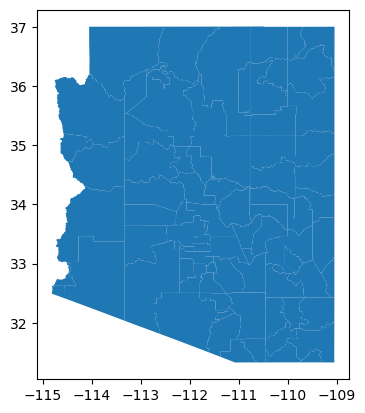

In [14]:
arizona.plot()

In [16]:
arizona.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Crop Arizona to Pheonix Region

In [22]:
pheonix = gpd.clip(arizona, bbox)

<Axes: >

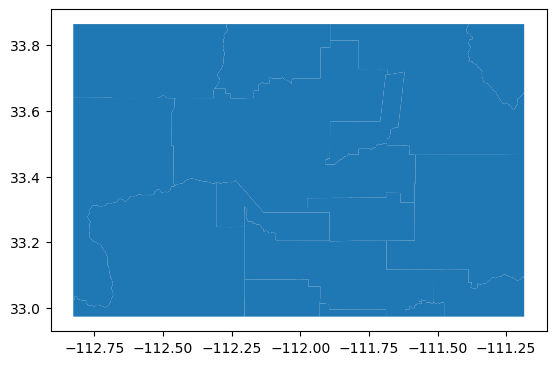

In [23]:
pheonix.plot()